In [83]:
import os
import json
import random
import numpy as np
from collections import Counter
from pathlib import Path

np.random.seed(42)

# FAILED: GEMMA, 'llama/llama_8b_31',

MODELS_QWEN = ['qwen/qwen_1b', 'qwen/qwen_32b', 'qwen/qwen_72b']
MODELS_MISTRAL = ['mixtral/mixtral_8x7b', 'mixtral/mixtral_8x22b']
MODELS_LLAMA = ['llama/llama_1b_32', 'llama/llama_3b_32', 'llama/llama_70b_33', 'llama/llama_405b_31']
MODELS_DEEPSEEK = ['deepseek/deepseek_v3']
MODELS_GPT = ['openai_gpt/gpt35_turbo', 'openai_gpt/gpt4o_mini', 'openai_gpt/o3_mini']

MODEL_DICT = {'qwen': MODELS_QWEN, 'mistral': MODELS_MISTRAL, 'llama': MODELS_LLAMA, 'deepseek': MODELS_DEEPSEEK}


def run_CoT_SC(dataset, llm, sampling_budget):
    try:
        with open(f'output/{llm}_{dataset}_fs_cot_40.json', 'r', encoding='utf-8') as f:
            data_ = json.load(f)
        with open(f'costs/{llm}_{dataset}_fs_cot_40_costs.json', 'r', encoding='utf-8') as f:
            cost_ = json.load(f)
    except:
        with open(f'output/{llm}_{dataset}_zs_cot_3.json', 'r', encoding='utf-8') as f:
            data_ = json.load(f)
        with open(f'costs/{llm}_{dataset}_fs_cot_3_costs.json', 'r', encoding='utf-8') as f:
            cost_ = json.load(f)

    correct = 0
    cost = []
    corr = []
    for i in range(len(data_["responses"])):
        true_answer = data_["responses"][i]["data_entry"]["answer"]
        if dataset in ['bigbench_date', 'bigbench_disambiguationQA', 'bigbench_geometric_shapes',
                       'bigbench_movie_recommendation', 'bigbench_penguins', 'bigbench_ruin_names', 'bigbench_snarks',
                       'bigbench_temporal_sequences']:
            true_answer = true_answer.replace('(', '').replace(')', '')

        try:
            ans_idx_ = np.random.choice(np.arange(len(data_["responses"][i]["decoded_answers"])), sampling_budget)

            sampled_ = [data_["responses"][i]["decoded_answers"][int(j)] for j in ans_idx_]
            counts_ = Counter(sampled_)
            final_answer = counts_.most_common(1)[0][0]

            cost_i = cost_['cost'][i]['ip_cost'] + np.sum([cost_['cost'][i]['op_cost'][int(j)] for j in ans_idx_])

            cost.append(cost_i)

            if dataset in ['bigbench_date', 'bigbench_disambiguationQA', 'bigbench_geometric_shapes',
                           'bigbench_movie_recommendation', 'bigbench_penguins', 'bigbench_ruin_names',
                           'bigbench_snarks', 'bigbench_temporal_sequences'] and final_answer is not None:
                final_answer = final_answer.replace('(', '').replace(')', '')
        except:
            final_answer = None
            cost.append(0.)

        if final_answer == true_answer:
            correct += 1
            corr.append(1)
        else:
            corr.append(0)

        acc__ = np.mean(corr)
        cost__ = np.mean(cost)

    print('------------------------')
    print('LLM: ', llm, ' , Budget: ', sampling_budget)
    print("Accuracy: ", acc__)
    print("Cost: ", cost__)

    return acc__, cost__, corr

def bootstrap_accuracy_scipy(acc_list,
                             n_resamples=1000,
                             ci_level=0.90,
                             random_seed=42):
    data = np.asarray(acc_list)
    orig_mean = data.mean()

    # SciPy's bootstrap expects a sequence of arrays (one per variable axis)
    res = bootstrap((data,),
                    np.mean,
                    confidence_level=ci_level,
                    n_resamples=n_resamples,
                    vectorized=False,
                    random_state=random_seed)

    # res.confidence_interval is a ConfidenceInterval(low, high)
    ci_low, ci_high = res.confidence_interval.low, res.confidence_interval.high
    print(orig_mean, ci_low, ci_high)
    return orig_mean, ci_low, ci_high

res_sc = {}
           
for sampling_budget in [5, 10, 15, 20, 25, 30, 35, 40]:
    acc_, cost_, corr = run_CoT_SC("aqua", "qwen/qwen_32b", sampling_budget)
    _, lo_, hi_ = bootstrap_accuracy_scipy(corr)
    res_sc[sampling_budget] = [acc_, lo_, hi_,  cost_]

print(res_sc)

------------------------
LLM:  qwen/qwen_32b  , Budget:  5
Accuracy:  0.8346456692913385
Cost:  0.00026920582677165353
0.8346456692913385 0.7913385826771654 0.8700787401574803
------------------------
LLM:  qwen/qwen_32b  , Budget:  10
Accuracy:  0.8700787401574803
Cost:  0.0005049719685039371
0.8700787401574803 0.8346456692913385 0.9015748031496063
------------------------
LLM:  qwen/qwen_32b  , Budget:  15
Accuracy:  0.8700787401574803
Cost:  0.0007462420472440944
0.8700787401574803 0.8346456692913385 0.9015748031496063
------------------------
LLM:  qwen/qwen_32b  , Budget:  20
Accuracy:  0.8503937007874016
Cost:  0.000980923937007874
0.8503937007874016 0.8110236220472441 0.8858254850668369
------------------------
LLM:  qwen/qwen_32b  , Budget:  25
Accuracy:  0.8582677165354331
Cost:  0.0012244656692913384
0.8582677165354331 0.8188976377952756 0.889763779527559
------------------------
LLM:  qwen/qwen_32b  , Budget:  30
Accuracy:  0.8700787401574803
Cost:  0.0014601420472440945
0.8

In [84]:
import os
import json
import random
import numpy as np
from collections import Counter
from pathlib import Path

np.random.seed(42)


def run_BoN(sampling_budget):
    with open(f'aqua_best_of_n_scored_cots_qwen32b.json', 'r', encoding='utf-8') as f:
        data_ = json.load(f)

    corr = []

    for q in data_['data']:
        answers = []
        scores = []
        true = q['entry']['answer']

        for cot in q['cots']:
            answers.append(cot['answer'])
            scores.append(cot['step_scores'][-1])

        ans_idx_ = np.random.choice(np.arange(len(answers)), 
                                    sampling_budget)
        answers_ = [answers[j] for j in ans_idx_]
        scores_ = [scores[j] for j in ans_idx_]
        
        if true == answers_[np.where(scores_==np.max(scores_))[0][0]]:
            corr.append(1.)
        else:
            corr.append(0.)

    print("Accuracy: ", np.mean(corr))
    return np.mean(corr)

res_bon = {}
           
for sampling_budget in [5, 10, 15, 20, 25, 30, 35, 40]:
    acc_ = run_BoN(sampling_budget)
  
    res_bon[sampling_budget] = acc_

print(res_bon)

Accuracy:  0.8543307086614174
Accuracy:  0.8622047244094488
Accuracy:  0.8661417322834646
Accuracy:  0.8622047244094488
Accuracy:  0.8582677165354331
Accuracy:  0.8622047244094488
Accuracy:  0.8818897637795275
Accuracy:  0.8661417322834646
{5: 0.8543307086614174, 10: 0.8622047244094488, 15: 0.8661417322834646, 20: 0.8622047244094488, 25: 0.8582677165354331, 30: 0.8622047244094488, 35: 0.8818897637795275, 40: 0.8661417322834646}


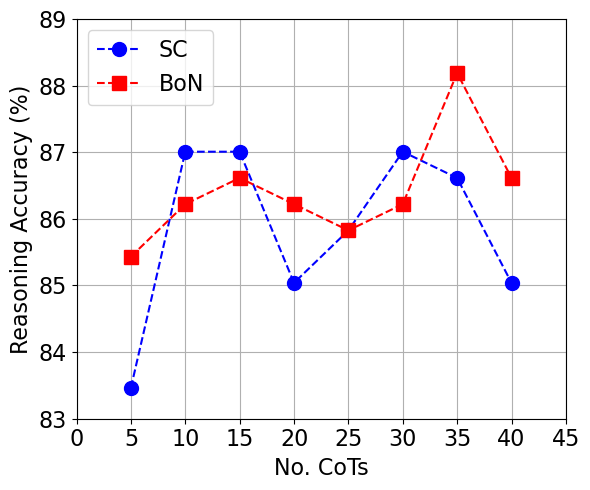

In [90]:
import matplotlib.pyplot as plt

# Example dictionaries
dict1 = res_sc
dict2 = res_bon

# Extract keys and values
keys = list(dict1.keys())
x = range(len(keys))  # Use positions for x-axis

# Values
values1 = [100*dict1[k][0] for k in keys]
values2 = [100*dict2[k] for k in keys]

low1 = [100*dict1[k][1] for k in keys]
high1 = [100*dict1[k][2] for k in keys]

# Plotting
plt.figure(figsize=(6, 5))
plt.plot(keys, values1, 'bo--', markersize=10, label='SC')
plt.plot(keys, values2, 'rs--', markersize=10, label='BoN')

# plt.fill_between(x, low1, high1, color='blue', alpha=0.2)

# Add labels
# plt.xticks(x, keys, fontsize=14)
ss=16
plt.xticks(fontsize=ss)
plt.yticks(fontsize=ss)
plt.xlabel('No. CoTs', fontsize=ss)
plt.ylabel('Reasoning Accuracy (%)', fontsize=ss)
plt.xlim([0, 45])
plt.ylim([83, 89])
# plt.title('Scatter Plot of Two Dictionaries')
plt.legend(loc='upper left', fontsize=ss)
plt.grid(True)
plt.tight_layout()

plt.savefig("aqua_sc_bon.pdf", format='pdf')
plt.show()


In [86]:
import os
import json
import random
import numpy as np
from collections import Counter
from pathlib import Path

np.random.seed(42)

# FAILED: GEMMA, 'llama/llama_8b_31',

MODELS_QWEN = ['qwen/qwen_1b', 'qwen/qwen_32b', 'qwen/qwen_72b']
MODELS_MISTRAL = ['mixtral/mixtral_8x7b', 'mixtral/mixtral_8x22b']
MODELS_LLAMA = ['llama/llama_1b_32', 'llama/llama_3b_32', 'llama/llama_70b_33', 'llama/llama_405b_31']
MODELS_DEEPSEEK = ['deepseek/deepseek_v3']
MODELS_GPT = ['openai_gpt/gpt35_turbo', 'openai_gpt/gpt4o_mini', 'openai_gpt/o3_mini']

# MODEL_DICT = {'qwen': MODELS_QWEN, 'mistral': MODELS_MISTRAL, 'llama': MODELS_LLAMA, 'deepseek': MODELS_DEEPSEEK}

def run_CoT_1D_Vote(dataset, weak_llm, strong_llm, sample_budget, threshold, N_cal):
    with open(f'output/{weak_llm}_{dataset}_fs_cot_40.json', 'r', encoding='utf-8') as f:
        data_w = json.load(f)
    with open(f'costs/{weak_llm}_{dataset}_fs_cot_40_costs.json', 'r', encoding='utf-8') as f:
        cost_w = json.load(f)

    try:
        with open(f'output/{strong_llm}_{dataset}_fs_cot_40.json', 'r', encoding='utf-8') as f:
            data_s = json.load(f)
        with open(f'costs/{strong_llm}_{dataset}_fs_cot_40_costs.json', 'r', encoding='utf-8') as f:
            cost_s = json.load(f)
    except:
        with open(f'output/{strong_llm}_{dataset}_zs_cot_3.json', 'r', encoding='utf-8') as f:
            data_s = json.load(f)
        with open(f'costs/{strong_llm}_{dataset}_fs_cot_3_costs.json', 'r', encoding='utf-8') as f:
            cost_s = json.load(f)

    correct = 0
    cost = []
    corr = []
    for i in np.arange(len(data_w["responses"])):
        true_answer = data_w["responses"][i]["data_entry"]["answer"]
        if dataset in ['bigbench_date', 'bigbench_disambiguationQA', 'bigbench_geometric_shapes', 'bigbench_movie_recommendation', 'bigbench_penguins', 'bigbench_ruin_names', 'bigbench_snarks', 'bigbench_temporal_sequences']:
            true_answer = true_answer.replace('(', '').replace(')', '')

        try:
            ans_idx_w = np.random.choice(np.arange(len(data_w["responses"][i]["decoded_answers"])), sample_budget)

            sampled_w = [data_w["responses"][i]["decoded_answers"][int(j)] for j in ans_idx_w]
            counts_w = Counter(sampled_w)
            answer_w = counts_w.most_common(1)[0][0]
            confidence_w = counts_w[answer_w] / sample_budget

            cost_i = cost_w['cost'][i]['ip_cost'] + np.sum([cost_w['cost'][i]['op_cost'][int(j)] for j in ans_idx_w])

            final_answer = answer_w
        except:
            final_answer = None
            cost_i = 0.
            confidence_w = 0.

        if confidence_w < threshold:
            try:
                ans_idx_s = np.random.choice(np.arange(len(data_s["responses"][i]["decoded_answers"])), sample_budget)

                sampled_s = [data_s["responses"][i]["decoded_answers"][int(j)] for j in ans_idx_s]
                counts_s = Counter(sampled_s)
                answer_s = counts_s.most_common(1)[0][0]

                cost_i += cost_s['cost'][i]['ip_cost'] + np.sum([cost_s['cost'][i]['op_cost'][int(j)] for j in ans_idx_s])

                final_answer = answer_s
            except:
                final_answer = None

        cost.append(cost_i)

        if dataset in ['bigbench_date', 'bigbench_disambiguationQA', 'bigbench_geometric_shapes', 'bigbench_movie_recommendation', 'bigbench_penguins', 'bigbench_ruin_names', 'bigbench_snarks', 'bigbench_temporal_sequences'] and final_answer is not None:
            final_answer = final_answer.replace('(', '').replace(')', '')

        if final_answer == true_answer:
            correct += 1
            corr.append(1.0)
        else:
            corr.append(0)

    acc = np.mean(corr)
    cost_avg = np.mean(cost)
    print('------------------------')
    print('Weak LLM: ', weak_llm)
    print('Strong LLM: ', strong_llm)
    print("Threshold: ", threshold)
    print("Accuracy: ", acc)
    print("Cost: ", cost_avg)

    return acc, cost_avg, corr

# Usage example

from scipy.stats import bootstrap
def bootstrap_accuracy_scipy(acc_list, 
                             n_resamples=1000, 
                             ci_level=0.90, 
                             random_seed=42):
    data = np.asarray(acc_list)
    orig_mean = data.mean()
    
    # SciPy's bootstrap expects a sequence of arrays (one per variable axis)
    res = bootstrap((data,), 
                    np.mean, 
                    confidence_level=ci_level,
                    n_resamples=n_resamples,
                    vectorized=False,
                    random_state=random_seed)
    
    # res.confidence_interval is a ConfidenceInterval(low, high)

    ci_low, ci_high = res.confidence_interval.low, res.confidence_interval.high
    print(orig_mean, ci_low, ci_high)
    return orig_mean, ci_low, ci_high
    


# for dataset in ['aqua', 'bigbench_causal_judgement', 'bigbench_date', 'bigbench_disambiguationQA',
#                 'bigbench_formal_fallacies', 'bigbench_geometric_shapes', 'bigbench_movie_recommendation',
#                 'bigbench_penguins', 'bigbench_ruin_names', 'bigbench_snarks', 'bigbench_sports',
#                 'bigbench_temporal_sequences', 'commonsenseQA', 'GSM8K', 'SVAMP', 'math_500']:
dataset = 'math_500'
family = 'LLAMA'

  # families = ["GPT", "LLAMA", "QWEN"]
N_cal = 50

  # for family in families:

print("Now running", dataset)

if family == 'GPT':
  weak_llm = 'openai_gpt/gpt35_turbo'
  strong_llm = 'openai_gpt/o3_mini'
elif family == 'QWEN':
  weak_llm = 'qwen/qwen_1b'
  strong_llm = 'qwen/qwen_72b'
elif family == 'LLAMA':
  weak_llm = 'llama/llama_1b_32'
  strong_llm = 'llama/llama_405b_31'
else:
  print('error!')

weak = fr'{weak_llm}'.split("/")[-1]
strong = fr'{strong_llm}'.split("/")[-1]
sample_budget = 5
Path(f"logs/{dataset}/MoT/{family}/boot").mkdir(parents=True, exist_ok=True)

res = {}
for threshold in np.arange(0.0, 0.999, 0.15):
  acc_, cost_, corr_ = run_CoT_1D_Vote(dataset, weak_llm, strong_llm, sample_budget, threshold, N_cal)
  if acc_ > 0 and acc_ < 1.0:
      acc, lo, hi = bootstrap_accuracy_scipy(corr_)
  else:
      acc = lo = hi = acc_
  res[cost_] = [acc, lo, hi]
# with open(f'logs/{dataset}/MoT/{family}/boot/{weak}_{strong}_budget_{sample_budget}.json', 'w+') as fp:
# json.dump(res, fp)

print(res)
res_mot = res

Now running math_500
------------------------
Weak LLM:  llama/llama_1b_32
Strong LLM:  llama/llama_405b_31
Threshold:  0.0
Accuracy:  0.134
Cost:  3.25488e-05
0.134 0.11 0.162
------------------------
Weak LLM:  llama/llama_1b_32
Strong LLM:  llama/llama_405b_31
Threshold:  0.15
Accuracy:  0.144
Cost:  3.1292300000000005e-05
0.144 0.12 0.172
------------------------
Weak LLM:  llama/llama_1b_32
Strong LLM:  llama/llama_405b_31
Threshold:  0.3
Accuracy:  0.236
Cost:  0.0014981764800000002
0.236 0.208 0.268
------------------------
Weak LLM:  llama/llama_1b_32
Strong LLM:  llama/llama_405b_31
Threshold:  0.44999999999999996
Accuracy:  0.49
Cost:  0.0039438103199999994
0.49 0.45330709289048066 0.528
------------------------
Weak LLM:  llama/llama_1b_32
Strong LLM:  llama/llama_405b_31
Threshold:  0.6
Accuracy:  0.504
Cost:  0.0039550099000000005
0.504 0.466 0.54
------------------------
Weak LLM:  llama/llama_1b_32
Strong LLM:  llama/llama_405b_31
Threshold:  0.75
Accuracy:  0.556
Cost: 

In [87]:
import os
import json, itertools
import random
import numpy as np
from collections import Counter
from pathlib import Path

np.random.seed(42)

# FAILED: GEMMA, 'llama/llama_8b_31',

MODELS_QWEN = ['qwen/qwen_1b', 'qwen/qwen_32b', 'qwen/qwen_72b']
MODELS_MISTRAL = ['mixtral/mixtral_8x7b', 'mixtral/mixtral_8x22b']
MODELS_LLAMA = ['llama/llama_1b_32', 'llama/llama_3b_32', 'llama/llama_70b_33', 'llama/llama_405b_31']
MODELS_DEEPSEEK = ['deepseek/deepseek_v3']

MODEL_DICT = {'qwen': MODELS_QWEN, 'mistral': MODELS_MISTRAL, 'llama': MODELS_LLAMA, 'deepseek': MODELS_DEEPSEEK}

def calculate_weight(answers):
    answers = [z for z in answers if z is not None]
    l = len(answers)

    answer__ = Counter(answers).most_common()

    unique_answers = [x_[0] for x_ in answer__]
    unique_weights = [x_[1] for x_ in answer__]
    unique_weights = unique_weights / np.sum(unique_weights)

    entropy = -np.sum(unique_weights * np.log(unique_weights))

    weight = 1 / l + (1 - 1/l)*(1 - entropy/np.log(l))
    return [weight] * l

def run_model_switch(dataset, llm_list, sample_budget, N_cal):
    data_all = {}
    cost_all = {}

    for llm in llm_list:
        try:
            with open(f'output/{llm}_{dataset}_fs_cot_40.json', 'r', encoding='utf-8') as f:
                data_ = json.load(f)
            with open(f'costs/{llm}_{dataset}_fs_cot_40_costs.json', 'r', encoding='utf-8') as f:
                cost_ = json.load(f)
        except:
            with open(f'output/{llm}_{dataset}_zs_cot_3.json', 'r', encoding='utf-8') as f:
                data_ = json.load(f)
            with open(f'costs/{llm}_{dataset}_fs_cot_3_costs.json', 'r', encoding='utf-8') as f:
                cost_ = json.load(f)

        data_all[llm] = data_
        cost_all[llm] = cost_

    correct = 0
    cost = []
    corr =[]
    for i in range(len(data_all[llm_list[0]]["responses"])):
        early_stop = False
        true_answer = data_all[llm_list[0]]["responses"][i]["data_entry"]["answer"]
        if dataset in ['bigbench_date', 'bigbench_disambiguationQA', 'bigbench_geometric_shapes', 'bigbench_movie_recommendation', 'bigbench_penguins', 'bigbench_ruin_names', 'bigbench_snarks', 'bigbench_temporal_sequences']:
            true_answer = true_answer.replace('(', '').replace(')', '')

        cost_i = 0.

        all_ans_i = []
        all_weights_i = []

        for llm in llm_list:
            try:
                ans_idx = np.random.choice(np.arange(len(data_all[llm]["responses"][i]["decoded_answers"])), sample_budget)
                sampled_ans = [data_all[llm]["responses"][i]["decoded_answers"][int(j)] for j in ans_idx]
            except:
                continue

            if dataset in ['bigbench_date', 'bigbench_disambiguationQA', 'bigbench_geometric_shapes',
                           'bigbench_movie_recommendation', 'bigbench_penguins', 'bigbench_ruin_names',
                           'bigbench_snarks', 'bigbench_temporal_sequences']:
                sampled_ans = [z.replace('(', '').replace(')', '') for z in sampled_ans if z is not None]

            cost_i += cost_all[llm]['cost'][i]['ip_cost'] + np.sum([cost_all[llm]['cost'][i]['op_cost'][int(j)] for j in ans_idx])

            try:
                counts_ = Counter([z for z in sampled_ans if z is not None])
                answer_ = counts_.most_common(1)[0][0]
                if len(counts_) == 1:
                    final_answer = answer_
                    early_stop = True
                    break
            except:
                print('Go to next LLM')

            else:
                all_ans_i += [z for z in sampled_ans if z is not None]
                all_weights_i += calculate_weight([z for z in sampled_ans if z is not None])

        if not early_stop:
            z = sorted(zip(all_ans_i, all_weights_i), key=lambda x__: x__[0])
            weighted_results = []
            for k, g in itertools.groupby(z, key=lambda x__: x__[0]):
                weighted_results.append((k, sum([t[1] for t in g])))

            weighted_results.sort(key=lambda x__: x__[1])
            final_answer = weighted_results[-1][0]

        cost.append(cost_i)

        if final_answer == true_answer:
            correct += 1
            corr.append(1.0)
        else:
            corr.append(0)

    acc = np.mean(corr)
    cost_avg = np.mean(cost)
    print('------------------------')
    print("Accuracy: ", acc)
    print("Cost: ", cost_avg)

    return acc, cost_avg, corr

from scipy.stats import bootstrap
def bootstrap_accuracy_scipy(acc_list, 
                             n_resamples=1000, 
                             ci_level=0.90, 
                             random_seed=42):
    data = np.asarray(acc_list)
    orig_mean = data.mean()
    
    # SciPy's bootstrap expects a sequence of arrays (one per variable axis)
    res = bootstrap((data,), 
                    np.mean, 
                    confidence_level=ci_level,
                    n_resamples=n_resamples,
                    vectorized=False,
                    random_state=random_seed)
    
    # res.confidence_interval is a ConfidenceInterval(low, high)
    ci_low, ci_high = res.confidence_interval.low, res.confidence_interval.high
    print(orig_mean, ci_low, ci_high)
    return orig_mean, ci_low, ci_high
    

dataset = 'math_500'
family = 'LLAMA'
N_cal = 50
sample_budget = 5



print("Now running", dataset)

if family == 'GPT':
    all_models = ['openai_gpt/gpt35_turbo', 'openai_gpt/gpt4o_mini', 'openai_gpt/o3_mini']
elif family == 'QWEN':
    all_models = ['qwen/qwen_1b', 'qwen/qwen_32b', 'qwen/qwen_72b']
elif family == 'LLAMA':
    all_models = ['llama/llama_1b_32', 'llama/llama_3b_32', 'llama/llama_70b_33', 'llama/llama_405b_31']
else:
    print('error!')



llm_list = all_models

Path(f"logs/{dataset}/Switch/{family}/boot").mkdir(parents=True, exist_ok=True)
# model_string = fr'{"".join(llm_list)}'.split("/")[-1]
acc_, cost_, corr_ = run_model_switch(dataset, llm_list, sample_budget, N_cal)
if acc_ > 0 and acc_ < 1.0:
    acc, lo, hi = bootstrap_accuracy_scipy(corr_)
else:
    acc = lo = hi = acc_

llm_list = fr'{"".join(llm_list)}'.split("/")
model_string = "-".join(llm_list)
res = {}
res[cost_] = [acc_, lo, hi]

res_ms = res
print(res)

Now running math_500
Go to next LLM
Go to next LLM
Go to next LLM
Go to next LLM
Go to next LLM
Go to next LLM
------------------------
Accuracy:  0.6
Cost:  0.00295911698
0.6 0.562 0.636
{0.00295911698: [0.6, 0.562, 0.636]}


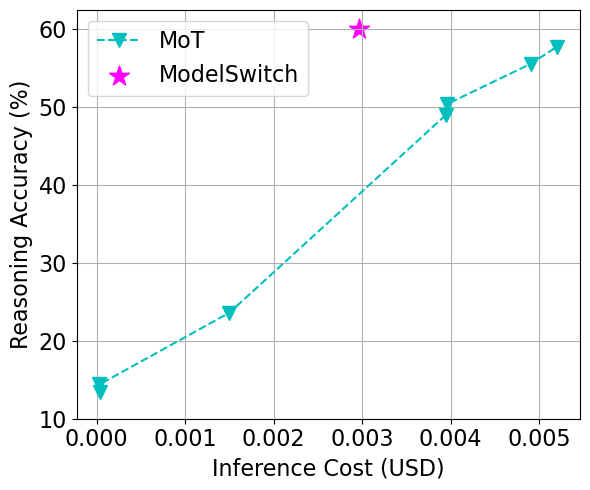

In [94]:
import matplotlib.pyplot as plt

# Example dictionaries
dict1 = res_mot
dict2 = res_ms

# Extract keys and values
# keys = list(dict1.keys())
# x = range(len(keys))  # Use positions for x-axis

# Values
values1 = [100*dict1[k][0] for k in list(dict1.keys())]
values2 = [100*dict2[k][0] for k in list(dict2.keys())]



# Plotting
plt.figure(figsize=(6, 5))
plt.plot(list(dict1.keys()), values1, 'cv--', markersize=10, label='MoT')
plt.scatter(list(dict2.keys()), values2, marker='*', s=225, color='magenta', label='ModelSwitch')

# plt.fill_between(x, low1, high1, color='blue', alpha=0.2)

# Add labels
ss=16
plt.xticks(fontsize=ss)
plt.yticks(fontsize=ss)
plt.xlabel('Inference Cost (USD)', fontsize=ss)
plt.ylabel('Reasoning Accuracy (%)', fontsize=ss)
plt.ylim([10, 62.5])
# plt.title('Scatter Plot of Two Dictionaries')
plt.legend(loc='upper left', fontsize=ss)
plt.grid(True)
plt.tight_layout()

plt.savefig("math_500_cascade.pdf", format='pdf')
plt.show()
